In [41]:
import pandas as pd
import re

# Specify the path to your Excel file
xlsx_path = 'solutions/summary_test/alns_results.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(xlsx_path)

# Print the DataFrame
df['instance'] = [df['instance'][i].split('_')[0] for i in range(len(df))]
df = df[['instance', 'end score']]
df.head()

,instance,end score
0,heur002,2318
1,heur002,2501
2,heur002,2515
3,heur002,2569
4,heur002,4547


In [42]:
grouped_df_alns = df.groupby('instance')['end score'].agg(['min', 'mean', 'max']).reset_index()
grouped_df_alns = grouped_df_alns.rename(columns={'instance': 'instance', 'min': 'min_alns', 'mean': 'mean_alns', 'max': 'max_alns'})
grouped_df_alns

,instance,min_alns,mean_alns,max_alns
0,heur002,2318,2890.0,4547
1,heur003,5452,5636.6,5899
2,heur004,5413,6018.0,6293
3,heur005,7784,8634.4,9639
4,heur006,11175,12934.2,13849
5,heur007,14879,15397.0,15893
6,heur008,1911,2107.4,2622
7,heur013,23358,24652.2,25643
8,heur014,36883,37841.6,39262
9,heur019,24004,31149.8,39589


In [43]:
file_path = 'solutions/summary_test/ga.txt'

# Read the data from the file
with open(file_path, 'r') as file:
    lines = file.readlines()

instances = []
avg_times_step = []
scores = []
changed_actual = []

for line in lines:
    if "data/inst_test/" in line:
        instances.append(re.search(r'\/([^\/]+)\.txt', line).group(1))
    elif "Average time per step" in line:
        avg_times_step.append(float(re.search(r'Average time per step: (.+?)s', line).group(1)))
    elif "Score" in line:
        scores.append(int(re.search(r'Score: (\d+)', line).group(1)))
    elif "Changed actual" in line:
        changed_actual.append(re.search(r'Changed actual: (\w+)', line).group(1) == 'True')
    
df = pd.DataFrame({
    'name': instances,
    'score': scores,
    'changed': changed_actual,
    'avg_step_time': avg_times_step
})

df['changed_numeric'] = df['changed'].astype(int)

# Define aggregation functions
agg_functions = {
    'score': ['mean', 'min', 'max'],
    'avg_step_time': ['mean', 'min', 'max'],
    'changed_numeric': 'mean'
}

# Group by 'name' and apply the aggregation functions
result_df_ga = df.groupby('name').agg(agg_functions).reset_index()

# Rename columns for clarity
result_df_ga.columns = ['name', 'mean_score', 'min_score', 'max_score', 'mean_avg_step_time', 'min_avg_step_time', 'max_avg_step_time', 'proportion_changed']

In [44]:
result_df_ga['name'] = [result_df_ga['name'][i].split('_')[0] for i in range(len(result_df_ga))]
result_df_ga = result_df_ga[['name', 'min_score','mean_score', 'max_score']]
result_df_ga = result_df_ga.rename(columns={'name': 'instance', 'min_score': 'min_ga', 'mean_score': 'mean_ga', 'max_score': 'max_ga'})
result_df_ga

,instance,min_ga,mean_ga,max_ga
0,heur002,2384,2560.4,2772
1,heur003,5466,5624.2,5718
2,heur004,6119,6275.0,6440
3,heur005,9070,9119.6,9210
4,heur006,12716,12998.4,13262
5,heur007,16097,16386.2,16576
6,heur008,1421,1487.2,1531
7,heur013,22307,26106.0,32772
8,heur014,37824,38499.0,38809
9,heur019,23839,37735.2,43402


In [47]:
merged_df = pd.merge(result_df_ga, grouped_df_alns, on='instance')
merged_df

,instance,min_ga,mean_ga,max_ga,min_alns,mean_alns,max_alns
0,heur002,2384,2560.4,2772,2318,2890.0,4547
1,heur003,5466,5624.2,5718,5452,5636.6,5899
2,heur004,6119,6275.0,6440,5413,6018.0,6293
3,heur005,9070,9119.6,9210,7784,8634.4,9639
4,heur006,12716,12998.4,13262,11175,12934.2,13849
5,heur007,16097,16386.2,16576,14879,15397.0,15893
6,heur008,1421,1487.2,1531,1911,2107.4,2622
7,heur013,22307,26106.0,32772,23358,24652.2,25643
8,heur014,37824,38499.0,38809,36883,37841.6,39262
9,heur019,23839,37735.2,43402,24004,31149.8,39589


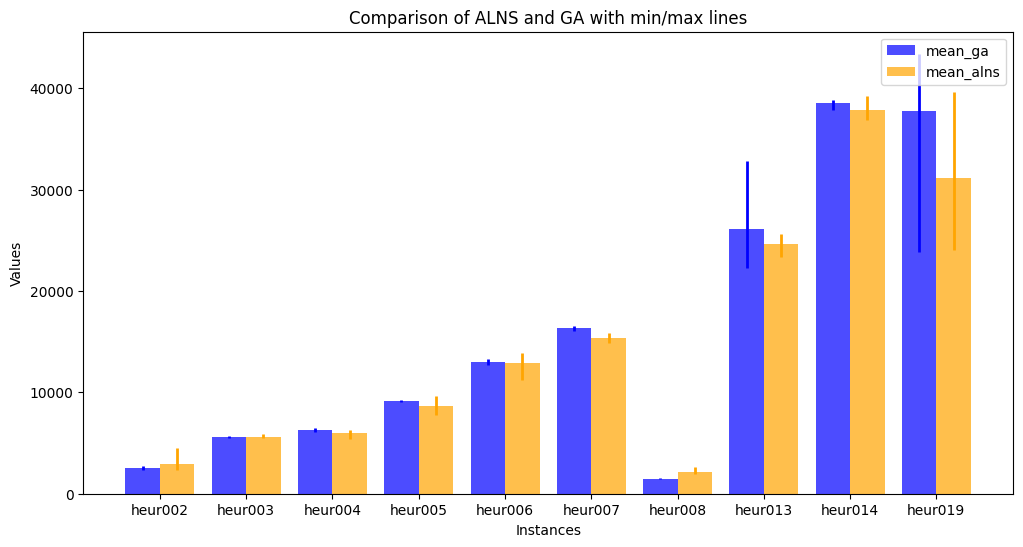

In [52]:
# Plotting
import matplotlib.pyplot as plt
import numpy as np
df = merged_df
fig, ax = plt.subplots(figsize=(12, 6))

# Bar positions
bar_positions_mean_ga = np.arange(len(df['instance']))
bar_positions_mean_alns = np.arange(len(df['instance'])) + 0.4  # Shift bars for mean_alns

# Plotting bars for mean_ga and mean_alns
ax.bar(bar_positions_mean_ga, df['mean_ga'], width=0.4, label='mean_ga', alpha=0.7, color='blue')
ax.bar(bar_positions_mean_alns, df['mean_alns'], width=0.4, label='mean_alns', alpha=0.7, color='orange')

# Plotting min-max lines on bars
for i, instance in enumerate(df['instance']):
    ax.vlines(bar_positions_mean_ga[i], df['min_ga'][i], df['max_ga'][i], colors='blue', linewidth=2)
    ax.vlines(bar_positions_mean_alns[i], df['min_alns'][i], df['max_alns'][i], colors='orange', linewidth=2)

# Set labels and title
ax.set_ylabel('Values')
ax.set_xlabel('Instances')
ax.set_title('Comparison of ALNS and GA with min/max lines')

# Set x-axis ticks and labels
ax.set_xticks(bar_positions_mean_alns - 0.2)
ax.set_xticklabels(df['instance'])

# Show legend
ax.legend()

# Show the plot
plt.show()

In [54]:
# Wilcoxon test for differences
ga_results = list(df['mean_ga'])
alns_results = list(df['mean_alns'])

In [55]:
import scipy

In [57]:
res = scipy.stats.wilcoxon(alns_results, ga_results, alternative = 'less')
print(res.pvalue)

0.052734375
